### Experimenting with **Bayes filter** in 2D gridworld

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
import PIL
from IPython.display import Image

In [2]:
def plot(img, cmap="Greys"):
    plt.gca().set_aspect("equal")
    plt.xticks([])
    plt.yticks([])
    plt.pcolormesh(img, edgecolors="black", linewidth=0.5, cmap=cmap)
    plt.show()

In [ ]:
# Assuming the robot already has a map of the environment! 
# Where does it think it is in this environment? -> only localization, not mapping 

In [3]:
game_counter = max(map(int, os.listdir("screenshots")))+1

In [203]:
SENSOR_LENGTH = 1
U, D, L, R = "UDLR"
MOTION_NOISE = 0.2  # chance that action fails (and position doesn't change)
SENSOR_NOISE = 0.1  # chance that any given feature of an observation gets bit-flipped

class Environment:
    
    # Initialization ----------------------------------------------------------------------------------------------
    def __init__(self, dim, n_obstacles):
        # Configuration
        global game_counter 
        self.dim = dim
        self.n_obstacles = n_obstacles
        self.action_space = [U, D, L, R]
        game_counter += 1
        self.game_id = game_counter
        if not os.path.exists(f"screenshots/{self.game_id}"):
            os.mkdir(f"screenshots/{self.game_id}")
        # Initializing observation, belief, etc.
        self.timestep = 0
        self.observation = None 
        self.initialize_grid()
        self.initialize_robot()
        self.initialize_belief()
    def initialize_grid(self):
        self.grid = np.zeros((self.dim, self.dim), dtype=int)
        self.grid[0,:] = 1
        self.grid[-1,:] = 1
        self.grid[:,0] = 1
        self.grid[:,-1] = 1
        for _ in range(self.n_obstacles):
            y, x = np.random.randint(1, self.dim-3, size=2)
            h, w = np.random.randint(1, 3, size=2)
            self.grid[y:y+h,x:x+w] = 1
    def initialize_robot(self, yx=None):
        if yx is None:
            possible_robot_coords = list(zip(*np.where(self.grid==0)))
            idx = np.random.choice(range(len(possible_robot_coords)))
            y, x = possible_robot_coords[idx]
            self.robot_y, self.robot_x = y.item(), x.item()
        else:
            y, x = yx
            self.robot_y, self.robot_x = y, x
    def initialize_belief(self):
        # uniform prior! 
        self.belief = np.ones((self.dim, self.dim))
        self.belief[self.grid == 1] = 0.0
        self.belief /= self.belief.sum()

    # Action ------------------------------------------------------------------------------------------------------
    def _compute_action(self, action, yx=None):
        """
        Compute new state from current state and a given action 
        to see what would happen in a perfect (non-noisy) environment
        """
        assert action in self.action_space, "Invalid action."
        if yx is None:
            y, x = self.robot_y, self.robot_x
        else:
            y, x = yx
        match action.upper():
            case "L":
                new_y, new_x = y, x-1 
            case "R":
                new_y, new_x = y, x+1 
            case "U":
                new_y, new_x = y+1, x
            case "D": 
                new_y, new_x = y-1, x
        if (0 <= new_y < self.dim) and (0 <= new_x < self.dim) and (not self.grid[new_y, new_x]):
            return new_y, new_x
        return y, x
    def action(self, action, render=True):
        """
        Actually perform action and move the robot accordingly 
        """
        new_y, new_x = self._compute_action(action)
        if np.random.uniform(0, 1) > MOTION_NOISE:
            self.robot_y, self.robot_x = new_y, new_x 
        else:
            # print("Action failed due to motion noise!")
            pass
        self.timestep += 1
        # !!! -----------------------------------------------------------------------------------------------------
        self.motion_belief_update(action)
        # self.observe()
        # self.sensor_belief_update()
        # !!! -----------------------------------------------------------------------------------------------------
        if render:
            # print((self.robot_y, self.robot_x))
            self.render()
    
    # Observation -------------------------------------------------------------------------------------------------
    def _compute_observation(self, yx=None):
        """
        Compute observation for a particular state 
        to see what would happen in a perfect (non-noisy) environment
        """
        if yx is None:
            y, x = self.robot_y, self.robot_x
        else:
            y, x = yx
        r = SENSOR_LENGTH  # "radius"
        # Pad the grid: add r cells of padding on each side
        padded = np.pad(self.grid, pad_width=r, mode="constant", constant_values=-1)
        # Shift (y, x) to match padded coordinates
        yp, xp = y+r, x+r
        observation = padded[yp-r:yp+r+1, xp-r:xp+r+1]
        # observation = self.grid[y-SENSOR_LENGTH:y+SENSOR_LENGTH+1, x-SENSOR_LENGTH:x+SENSOR_LENGTH+1]
        return observation
    def observe(self):
        """ 
        Get observation from the grid for current position.
        Observation is defined as 8 neighboring cells to the robot 
        which are either 0 (free) or 1 (blocked)
        Each bit in this observation has a chance of SENSOR_NOISE of being flipped 
        """
        observation = self._compute_observation()
        flat_observation = observation.reshape(-1)  # feature vector 
        was_corrupted = False
        for i, feature in enumerate(flat_observation):
            if np.random.uniform(0, 1) < SENSOR_NOISE:
                was_corrupted = True
                flat_observation[i] = 1-feature
        if was_corrupted:
            # print(f"Observation was corrupted due to sensor noise!")
            pass 
        observation = flat_observation.reshape(observation.shape)
        self.observation = observation
    
    # Bayes filter ------------------------------------------------------------------------------------------------
    # Motion update -----------------------------------------------------------------------------------------------
    def motion_model(self, prev_state, action):
        """
        Given the robot's previous state and action, calculate the transition probabilities 
        to all possible new states, accounting for motion noise.
        
        prev_state: (y, x) -> the previous robot location.
        action: str -> one of 'U', 'D', 'L', 'R' for up, down, left, right.
        
        Returns: A 2D numpy array of probabilities P(x_t | u_t, x_(t-1)) for all possible states x_t.
        """
        # Get the intended next state given the action
        y, x = prev_state
        y_intended, x_intended = self._compute_action(action, prev_state)
        
        # Initialize transition probability matrix with zeros
        p = np.zeros(self.grid.shape)
        
        # If the intended cell is not blocked
        if 0 <= y_intended < self.dim and 0 <= x_intended < self.dim and not self.grid[y_intended, x_intended]:
            # Probability of reaching the intended state (successful action)
            p[y_intended, x_intended] = 1 - MOTION_NOISE
        # If the intended cell is blocked or out of bounds
        else:
            # If the intended cell is blocked or out of bounds, robot stays in the same state
            p[y, x] = 1 - MOTION_NOISE
        
        # Handle the case where the robot stays in the same location (due to motion noise)
        p[y, x] += MOTION_NOISE
        
        return p
    def motion_belief_update(self, action):
        """
        Update the robot's belief about its position after taking an action, 
        using the motion model and previous belief.
        
        action: str -> action taken by the robot ('U', 'D', 'L', 'R')
        """
        # Create a new belief matrix to store the updated belief after action
        new_belief = np.zeros(self.belief.shape)
        
        # Iterate over all possible states in the grid (all (y, x) positions)
        for y, x in np.ndindex(self.grid.shape):
            # Compute the sum of probabilities over all previous states (prev_y, prev_x)
            # For each possible previous state, use the motion model to get transition probabilities
            for prev_y, prev_x in np.ndindex(self.grid.shape):
                # Transition probability from previous state (prev_y, prev_x) to current state (y, x)
                transition_prob = self.motion_model((prev_y, prev_x), action)
                
                # Multiply the transition probability by the belief at the previous state
                new_belief[y, x] += transition_prob[y, x] * self.belief[prev_y, prev_x]
        
        # Set belief in blocked cells to 0 (since the robot can't be there)
        new_belief[self.grid == 1] = 0
        
        # Normalize the belief so that it sums to 1.0 (important for valid probability distribution)
        total_belief = new_belief.sum()
        if total_belief > 0:
            new_belief /= total_belief
        else:
            # If belief sum is zero (e.g., all possible locations are blocked), reset to uniform belief
            new_belief = np.ones_like(new_belief) / new_belief.size
        
        # Update the robot's belief with the newly computed belief
        self.belief = new_belief
    '''
    def motion_model(self, prev_state, action):
        """
        action: u[t]
        prev_state: x[t-1]
        Takes x[t-1] and u[t] and returns P(x[t]|u[t],x[t-1]) for all x[t] 
        So, if the robot were in x[t-1] and took action u[t] what's the 
        probability it ends up in x[t], for all x[t] 
        We can look at the map because in this setup we assume it is known! 
        """
        y, x = prev_state
        y_intended, x_intended = self._compute_action(action, prev_state)
        p = np.zeros(self.grid.shape)
        if (y, x) == (y_intended, x_intended):
            p[y, x] = 1.0 
        else:
            if self.grid[y_intended, x_intended] == 0:
                # If intended cell is free, (1-MOTION_NOISE) chance that the robot made it there, 
                # MOTION_NOISE chance that it didn't move due to motion noise. 
                p[y_intended, x_intended] = 1-MOTION_NOISE
                p[y, x] = MOTION_NOISE
            else:
                # If intended cell is blocked, 100% certain that we are still in the same cell as before
                p[y, x] = 1.0 
        # p /= p.sum()
        assert np.isclose(p.sum(), 1.0), "p.sum() is not close to 1.0"
        return p
    def motion_belief_update(self, action):
        """
        aka action update
        """
        # TODO: this is inefficient as most cells do not even have to be checked 
        #  as they are unreachable 
        #  It should be enough to look at the neighbors! 
        belief = np.zeros(self.belief.shape)
        for y, x in np.ndindex(self.grid.shape):
            # state: (y, x)
            s = 0
            for prev_y, prev_x in np.ndindex(self.grid.shape):
                # prev_state: (prev_y, prev_x)
                p = self.motion_model((prev_y, prev_x), action)
                s += p[y, x] * self.belief[prev_y, prev_x]
            belief[y, x] = s
        # Force the belief in blocked cells to 0:
        belief[self.grid == 1] = 0.0
        belief /= belief.sum()
        self.belief = belief
    '''
    # Sensor update -----------------------------------------------------------------------------------------------
    def sensor_model(self, state, true_observation):
        """
        """
        sensor_accuracy = 1-SENSOR_NOISE
        y, x = state
        # What the robot *should* see in this state:
        expected_observation = self._compute_observation(state).reshape(-1)  
        prob = 1.0
        for true_feature, expected_feature in zip(true_observation.reshape(-1), expected_observation):
            if true_feature == expected_feature:
                # If true observation == expected observation, this state is likely! 
                prob *= sensor_accuracy
            else:
                # if true observation != expected observation, this state is unlikely! 
                # if SENSOR_ACCURACY==1, then the prob of this state is simply 0 
                prob *= 1-sensor_accuracy
        return prob
    def sensor_belief_update(self):
        """
        aka observation update, measurement update, correction
        """
        belief = np.zeros(self.belief.shape)
        for y, x in np.ndindex(self.grid.shape):
            # state: (y, x)
            likelihood = self.sensor_model((y, x), self.observation)
            belief[y, x] = likelihood * self.belief[y, x]
        # Force the belief in blocked cells to 0:
        belief[self.grid == 1] = 0.0
        eta = belief.sum()
        if eta > 0:
            belief /= eta
            self.belief = belief

    # Rendering ---------------------------------------------------------------------------------------------------
    def render(self, grid=None, yx=None):
        fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
        for ax in axes:
            ax.set_aspect("equal")
            ax.set_xticks([])
            ax.set_yticks([])
        # Observation:
        axes[0].set_title("Observation")
        if self.observation is not None:
            observation = self.observation.copy()
            observation[observation == -1] = 0
            axes[0].pcolormesh(observation, edgecolors="black", linewidth=0.5, cmap="Greys")
        # Environment:
        axes[1].set_title("Ground truth")
        axes[1].pcolormesh(self.grid, edgecolors="black", linewidth=0.5, cmap="Greys")
        # Robot:
        actual_location = np.zeros((*self.grid.shape, 4))
        actual_location[self.robot_y, self.robot_x, :] = 1, 0, 0, 1
        axes[1].pcolormesh(actual_location)
        # Belief:
        axes[2].set_title("Belief")
        axes[2].pcolormesh(self.belief, edgecolors="black", linewidth=0.5)
        plt.tight_layout()
        plt.savefig(f"screenshots/{self.game_id}/{self.timestep}.png")
    def gif(self):
        """
        Create gif from screenshots (one screenshot per timestep) 
        """
        # Save as GIF with loop=0 (infinite looping)
        images = []
        for filename in os.listdir(f"screenshots/{self.game_id}"):
            if filename.endswith(".png"):
                images.append(PIL.Image.open(f"screenshots/{self.game_id}/{filename}"))
        images[0].save(
            f"gifs/{self.game_id}.gif",
            save_all=True,
            append_images=images[1:],
            # duration=100,  # ms per frame
            loop=0  # 0 = loop forever
        )
        return Image(f"gifs/{self.game_id}.gif")

---

#### Motion model (transition probabilities) 

In [205]:
def plot_motion_model(p, yx=None):
    fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
    for ax in axes:
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])
    # Environment:
    axes[0].set_title("Ground truth")
    axes[0].pcolormesh(env.grid, edgecolors="black", linewidth=0.5, cmap="Greys")
    # Robot:
    if yx is not None:
        y, x = yx
        robot_location = np.zeros((*env.grid.shape, 4))
        robot_location[y, x, :] = 1, 0, 0, 1
        axes[0].pcolormesh(robot_location)
    # Transition probabilities: 
    axes[1].set_title("Motion model")
    axes[1].pcolormesh(p, edgecolors="black", linewidth=0.5) 
    plt.tight_layout()

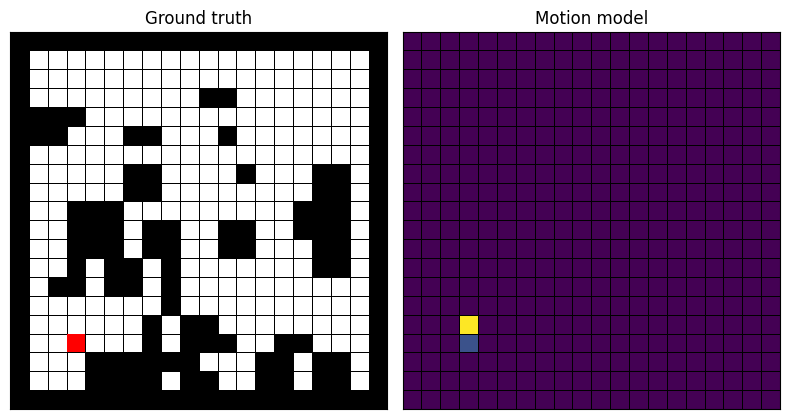

In [206]:
# E.g. if we are in state (1, 1) and take action U, what are the transition probabilities? 
y, x = 3, 3
p = env.motion_model((y, x), U)
plot_motion_model(p, (y, x))

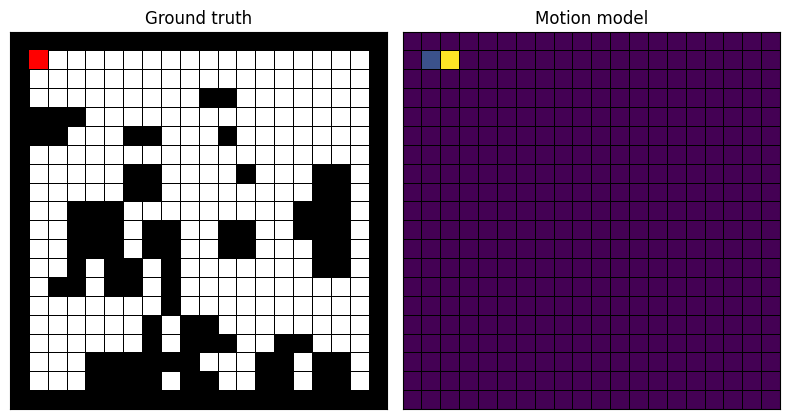

In [207]:
y, x = 18, 1
p = env.motion_model((y, x), R)
plot_motion_model(p, (y, x))

In [94]:
def plot_full_motion_model(self, action):
    # Sum over all previous states (prev_y, prev_x) for the motion update.
    q = np.zeros(self.grid.shape)
    for prev_y, prev_x in np.ndindex(self.dim, self.dim):
        # Get the transition probability from prev_state to current state after action
        q += self.motion_model((prev_y, prev_x), action)
    q[self.grid == 1] = 0.0
    # Normalize the belief so that it sums to 1.0.
    q_sum = q.sum()
    if q_sum > 0:
        q /= q_sum  # Normalize so that the belief sums to 1
    else:
        # If belief sum is zero (e.g., all possible locations are blocked), reset to uniform belief
        q = np.ones_like(q)/q.size
    # Set the updated belief as the new belief.
    plot_motion_model(q)

U
D
L
R


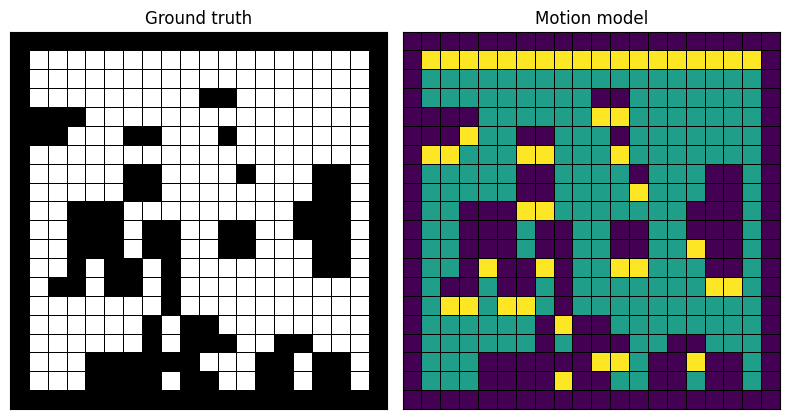

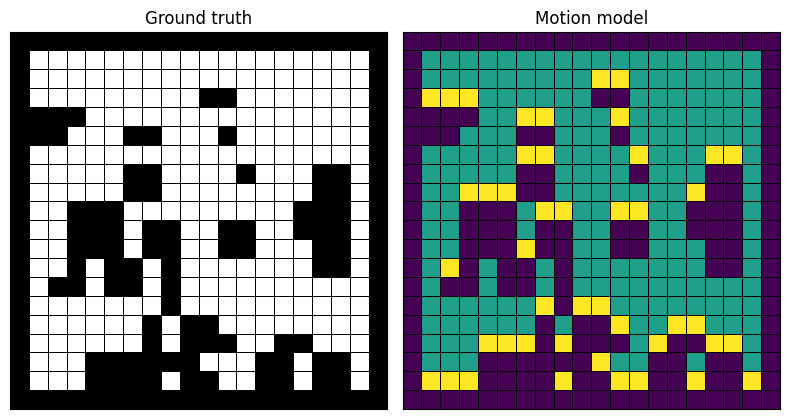

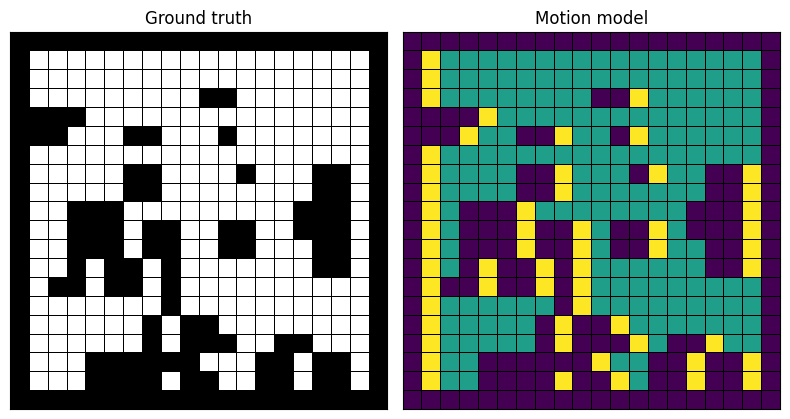

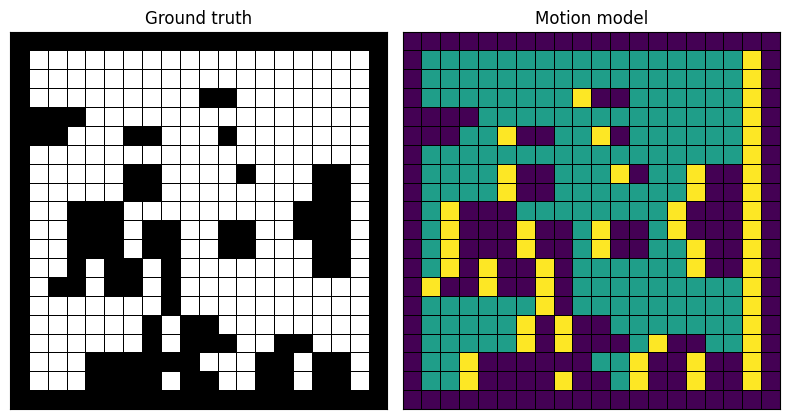

In [208]:
for action in env.action_space:
    print(action)
    plot_full_motion_model(env,  action)

---

#### Sensor model (observation likelihoods)

In [183]:
def plot_sensor_model(p, yx, true_observation): 
    fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
    for ax in axes:
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])
    # Observation:
    axes[0].set_title("Observation")
    axes[0].pcolormesh(true_observation, edgecolors="black", linewidth=0.5, cmap="Greys")
    # Environment:
    axes[1].set_title("Ground truth")
    axes[1].pcolormesh(env.grid, edgecolors="black", linewidth=0.5, cmap="Greys")
    # Robot:
    y, x = yx
    robot_location = np.zeros((*env.grid.shape, 4))
    robot_location[y, x, :] = 1, 0, 0, 1
    axes[1].pcolormesh(robot_location)
    # Transition probabilities: 
    axes[2].set_title("Sensor model")
    axes[2].pcolormesh(p, edgecolors="black", linewidth=0.5) 
    plt.tight_layout()

# Get full sensor model likelihood map
def get_likelihood_map(env, true_observation):
    # Simply apply the sensor model to each state observation 
    #  relative to one given true_observation!
    p = np.zeros(env.grid.shape)
    for _y, _x in np.ndindex(env.grid.shape):
        # state: (y, x)
        p[_y, _x] = env.sensor_model((_y, _x), true_observation)
    return p

In [184]:
# E.g. if we are in state (1, 1) we would expect this observation: 
y, x = 1, 1
true_observation = env.grid[y-SENSOR_LENGTH:y+SENSOR_LENGTH+1, x-SENSOR_LENGTH:x+SENSOR_LENGTH+1]
print(true_observation.reshape(-1))

# which is why the sensor model gives it very high probability
env.sensor_model((1, 1), true_observation)

[1 1 1 1 0 0 1 1 0]


1.0

In [185]:
# for this other random observation, it should return very low probability: 
y2, x2 = 2, 2
different_observation = env.grid[y2-SENSOR_LENGTH:y2+SENSOR_LENGTH+1, x2-SENSOR_LENGTH:x2+SENSOR_LENGTH+1]
print(different_observation.reshape(-1))

env.sensor_model((1, 1), different_observation.reshape(-1))

[0 0 0 1 0 0 1 1 0]


0.0

In [187]:
env = Environment(dim=20, n_obstacles=20)

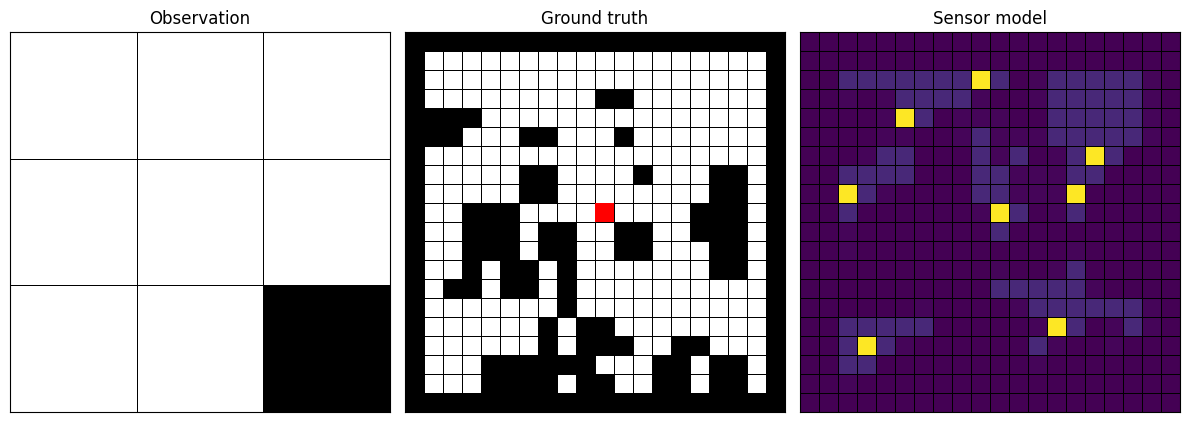

In [204]:
# Now let's visualize the probability of each state's expected observation
# relative to the actual observation to see how likely they are (under some sensor noise)

y, x = 10, 10
true_observation = env.grid[y-1:y+2, x-1:x+2]
p = get_likelihood_map(env, true_observation)
plot_sensor_model(p, (y, x), true_observation)

---

#### Example run

In [ ]:
env = Environment(dim=20, n_obstacles=40)
env.render()

In [ ]:
# Take a bunch of random actions and see how/if the belief converges
for iteration in range(10):
    action = np.random.choice(env.action_space)
    env.action(action)

In [ ]:
# env.gif()